## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [3]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [38]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
UKY
	Components:
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
	Site Interfaces:
RENC
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		Smart

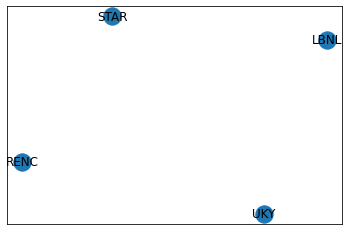

In [6]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In Release 1.0, user is expected to assign the IP addresses manually. Please use the example comands indicated below:

### Run on Node N1
```
ip addr add 192.168.10.51/24 dev eth1
```
### Run on Node N2
```
ip addr add 192.168.10.52/24 dev eth1
```
### Run on Node N3
```
ip addr add 192.168.10.53/24 dev eth1
```

In [43]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='UKY')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
n2 = t.add_node(name='n2', site='RENC')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n3 = t.add_node(name='n3', site='RENC')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Shared Cards
n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')
n3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n3-nic1')

# L2STS Service
t.add_network_service(name='sts1', nstype=ServiceType.L2STS,
                      interfaces=[n1.interface_list[0], n2.interface_list[0], n3.interface_list[0]])

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-sts-ded', slice_graph=slice_graph, ssh_key=ssh_key_pub)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "25d5a305-24e4-4fe5-885c-4337d37cd3fe",
    "lease_end": "2021-09-08 18:51:29",
    "pending_state": "None_",
    "reservation_id": "755dbded-edeb-45ed-bb20-a4b83df6854c",
    "reservation_state": "Unknown",
    "slice_id": "dffa9f3b-0aed-4cb7-87ef-f1b668724e14"
}, {
    "graph_node_id": "4bff59db-a4dc-4dbe-8203-46b6a72113c2",
    "lease_end": "2021-09-08 18:51:29",
    "pending_state": "None_",
    "reservation_id": "0bd9ca6d-742f-4d99-84a8-0d16268006b6",
    "reservation_state": "Unknown",
    "slice_id": "dffa9f3b-0aed-4cb7-87ef-f1b668724e14"
}, {
    "graph_node_id": "0f02a8e2-d1c5-4a89-840e-07e3f92fd8b6",
    "lease_end": "2021-09-08 18:51:29",
    "pending_state": "None_",
    "reservation_id": "642d2da4-e59c-4520-8ed9-b53dc83040f2",
    "reservation_state": "Unknown",
    "slice_id": "dffa9f3b-0aed-4cb7-87ef-f1b668724e14"
}, {
    "graph_node_id": "f062beee-731a-477a-9086-b7dc8f41e637",
    "lease_end": "2021

In [44]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id
print(slice_id)

dffa9f3b-0aed-4cb7-87ef-f1b668724e14


## Query Slices

In [46]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "c758ff0d-22f6-4195-89fe-500b5e4392bf",
    "lease_end": "2021-09-04 00:13:06",
    "slice_id": "060aa897-aa4b-4d5a-93c6-4403dbdef3af",
    "slice_name": "Slice-l2p2p-ded",
    "slice_state": "Closing"
}, {
    "graph_id": "343c1157-2d7a-4043-9762-e6ca19596cf2",
    "lease_end": "2021-09-04 00:17:40",
    "slice_id": "eb71d173-0afa-48d0-b048-d5cde51a9e34",
    "slice_name": "Slice-l2p2p-ded",
    "slice_state": "Closing"
}, {
    "graph_id": "bbdac2cc-6d88-4595-9146-23bfe1e356c4",
    "lease_end": "2021-09-04 00:20:09",
    "slice_id": "7f6c4a55-09fa-4af6-8843-918d2d9f4e04",
    "slice_name": "Slice-l2p2p-ded",
    "slice_state": "Dead"
}, {
    "graph_id": "c7f92e4c-3637-46cc-b81e-33f86c9e7311",
    "lease_end": "2021-09-04 00:33:30",
    "slice_id": "6008f977-bf2a-4003-9a63-5331a8af2f62",
    "slice_name": "Slice-l2p2p-ded",
    "slice_state": "Dead"
}, {
    "graph_id": "bb1ff254-c4fc-486d-ac2f-ca72f6e19993",
    "lease_end": "2021

## Query Slivers

In [47]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-00000206\", \"instance_parent\": \"renc-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "0f02a8e2-d1c5-4a89-840e-07e3f92fd8b6",
    "join_state": "NoJoin",
    "lease_end": "2021-09-08 18:51:29",
    "management_ip": "152.54.15.47",
    "name": "n3",
    "pending_state": "None_",
    "reservation_id": "642d2da4-e59c-4520-8ed9-b53dc83040f2",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "RENC",
    "slice_id": "dffa9f3b-0aed-4cb7-87ef-f1b668724e14"
}, {
    "graph_node_id": "f062beee-731a-477a-9086-b7dc8f41e637",
    "join_state": "NoJoin",
    "lease_end": "2021-09-08 18:51:29",
    "name": "sts1",
    "pending_state": "None_",
    "reservation_id": "a5d7135d-ba38-4f88-8477-e5

## Sliver Status

In [34]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=s.reservation_id)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance_parent\": \"renc-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "972f6745-6b80-4a5a-a942-33121a3d1040",
    "join_state": "NoJoin",
    "lease_end": "2021-09-08 18:37:26",
    "name": "n2",
    "notices": "Reservation 7b6766a0-a359-4d73-a39a-44876b99ac8d (Slice Slice-sts-ded(e3e499b2-46ca-4488-972f-169a6d69fd21) Graph Id:659a415e-cc29-499c-9001-54500c85fee7 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Closed,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: all units failed priming: Exception during create for unit: 7b6766a0-a359-4d73-a39a-44876b99ac8d Playbook has failed tasks: Timeout waiting for the floating IP to be attached.\nTicket 

### Now let's connect to the nodes.

In [48]:
import paramiko

In [49]:
n1_ip = list(filter(lambda sliver : sliver.name == "n1",slivers))[0].management_ip
n1_ip

'128.163.179.29'

In [50]:
n2_ip = list(filter(lambda sliver : sliver.name == "n2",slivers))[0].management_ip
n2_ip

'152.54.15.47'

In [51]:
n3_ip = list(filter(lambda sliver : sliver.name == "n3",slivers))[0].management_ip
n3_ip

'152.54.15.47'

In [52]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientn1 = paramiko.SSHClient()
clientn1.load_system_host_keys()
clientn1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientn1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientn1.connect(n1_ip,username='ubuntu',pkey = key)

clientn1

In [53]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientn2 = paramiko.SSHClient()
clientn2.load_system_host_keys()
clientn2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientn2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientn2.connect(n2_ip,username='ubuntu',pkey = key)

clientn2

In [54]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
clientn3 = paramiko.SSHClient()
clientn3.load_system_host_keys()
clientn3.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

clientn3.set_missing_host_key_policy(paramiko.AutoAddPolicy())
clientn3.connect(n3_ip,username='ubuntu',pkey = key)

clientn3

### First, let's look at our network interfaces.

In [58]:
stdin, stdout, stderr = clientn1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:ed:7a:89 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.108/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86098sec preferred_lft 86098sec
    inet6 fe80::f816:3eff:feed:7a89/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:ea:c7:50 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.51/24 scope global ens7
       valid_lft forever preferred_lft forever
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    l

In [59]:
stdin, stdout, stderr = clientn2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:2d:ba:57 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.30/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86089sec preferred_lft 86089sec
    inet6 fe80::f816:3eff:fe2d:ba57/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:74 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:75 brd ff:ff:ff:ff:ff:ff




In [56]:
stdin, stdout, stderr = clientn3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:2d:ba:57 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.30/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86103sec preferred_lft 86103sec
    inet6 fe80::f816:3eff:fe2d:ba57/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:74 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:b7:15:75 brd ff:ff:ff:ff:ff:ff




### Now we just issue the commands that assign IP addresses to the interfaces. And we also need to activate the interfaces.

In [57]:
stdin, stdout, stderr = clientn1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [61]:
stdin, stdout, stderr = clientn1.exec_command('sudo ip link set ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [62]:
stdin, stdout, stderr = clientn2.exec_command('sudo ip addr add 192.168.10.52/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [63]:
stdin, stdout, stderr = clientn2.exec_command('sudo ip link set ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [64]:
stdin, stdout, stderr = clientn3.exec_command('sudo ip addr add 192.168.10.53/24 dev ens7')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [65]:
stdin, stdout, stderr = clientn3.exec_command('sudo ip link set ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Now let's take another look at the network interfaces.

In [66]:
stdin, stdout, stderr = clientn1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:ed:7a:89 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.108/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85990sec preferred_lft 85990sec
    inet6 fe80::f816:3eff:feed:7a89/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 0c:42:a1:ea:c7:50 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.51/24 scope global ens7
       valid_lft forever preferred_lft forever
    inet6 fe80::e42:a1ff:feea:c750/64 scope link 
       valid_lft forever preferre

In [67]:
stdin, stdout, stderr = clientn2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:2d:ba:57 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.30/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85980sec preferred_lft 85980sec
    inet6 fe80::f816:3eff:fe2d:ba57/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 04:3f:72:b7:15:74 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.52/24 scope global ens7
       valid_lft forever preferred_lft forever
    inet 192.168.10.53/24 scope global secondary ens7
       valid_lft forever prefe

In [68]:
stdin, stdout, stderr = clientn3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:2d:ba:57 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.30/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85973sec preferred_lft 85973sec
    inet6 fe80::f816:3eff:fe2d:ba57/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 04:3f:72:b7:15:74 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.52/24 scope global ens7
       valid_lft forever preferred_lft forever
    inet 192.168.10.53/24 scope global secondary ens7
       valid_lft forever prefe

### We can see that the IP addresses have been assigned, and that the interfaces are up and ready.

### Now let's ping.

In [69]:
stdin, stdout, stderr = clientn1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=43.5 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=21.7 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=21.6 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=21.7 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=21.6 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 21.614/26.023/43.524/8.750 ms




In [70]:
stdin, stdout, stderr = clientn1.exec_command('ping -c 5 192.168.10.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.53 (192.168.10.53) 56(84) bytes of data.
64 bytes from 192.168.10.53: icmp_seq=1 ttl=64 time=43.4 ms
64 bytes from 192.168.10.53: icmp_seq=2 ttl=64 time=21.7 ms
64 bytes from 192.168.10.53: icmp_seq=3 ttl=64 time=21.6 ms
64 bytes from 192.168.10.53: icmp_seq=4 ttl=64 time=21.6 ms
64 bytes from 192.168.10.53: icmp_seq=5 ttl=64 time=21.6 ms

--- 192.168.10.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 21.624/25.988/43.395/8.703 ms




In [71]:
stdin, stdout, stderr = clientn2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=21.7 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=21.6 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 21.622/21.652/21.741/0.044 ms




In [72]:
stdin, stdout, stderr = clientn2.exec_command('ping -c 5 192.168.10.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.53 (192.168.10.53) 56(84) bytes of data.
64 bytes from 192.168.10.53: icmp_seq=1 ttl=64 time=0.011 ms
64 bytes from 192.168.10.53: icmp_seq=2 ttl=64 time=0.009 ms
64 bytes from 192.168.10.53: icmp_seq=3 ttl=64 time=0.031 ms
64 bytes from 192.168.10.53: icmp_seq=4 ttl=64 time=0.008 ms
64 bytes from 192.168.10.53: icmp_seq=5 ttl=64 time=0.011 ms

--- 192.168.10.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.008/0.014/0.031/0.008 ms




In [73]:
stdin, stdout, stderr = clientn3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=21.6 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=21.7 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=21.6 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4007ms
rtt min/avg/max/mdev = 21.628/21.646/21.711/0.032 ms




In [74]:
stdin, stdout, stderr = clientn3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.011 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.012 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.006 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.007 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.014 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4099ms
rtt min/avg/max/mdev = 0.006/0.010/0.014/0.003 ms




### We can see from the pings above that each node can see the other two nodes. Experiment complete.

### Finally, you can delete the slice with the following cell.

In [57]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
